In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.utils.data
from sklearn.model_selection import KFold

In [4]:
# load all data
data = pd.read_csv('SFEW.csv',  header=None, skiprows=1)

# drop first column
data.drop(data.columns[0], axis=1, inplace=True)

# try shuffle data
data = data.sample(frac=1).reset_index(drop=True)

#preprocessing????
for column in data:
    if column == 1:
        pass
    else:
        data[column] = data.loc[:, [column]].apply(lambda x: (x - x.mean()) / x.std())

#reorder
data = data[[2,3,4,5,6,7,8,9,10,11,1]]
        
# randomly split data into training set (80%) and testing set (20%)
msk = np.random.rand(len(data)) < 0.8
train_data = data[msk]
test_data = data[~msk]

In [5]:
train_LPQ_x = torch.Tensor(train_data.iloc[:, 0:5].values)
train_PHOG_x = torch.Tensor(train_data.iloc[:, 5:10].values)
train_y = torch.Tensor(train_data.iloc[:, 10].values-1).long()

train_LPQ_dataset = torch.utils.data.TensorDataset(train_LPQ_x, train_y)
train_PHOG_dataset = torch.utils.data.TensorDataset(train_PHOG_x, train_y)

train_LPQ_loader = torch.utils.data.DataLoader(train_LPQ_dataset, batch_size=32, shuffle=True)
train_PHOG_loader = torch.utils.data.DataLoader(train_PHOG_dataset, batch_size=32, shuffle=True)

test_LPQ_x = torch.Tensor(test_data.iloc[:, 0:5].values)
test_PHOG_x = torch.Tensor(test_data.iloc[:, 5:10].values)
test_y = torch.Tensor(test_data.iloc[:, 10].values-1).long()

In [6]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.out(out)
        return out

net = Net(5, 100, 7)

In [7]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

In [8]:
# define a function to plot confusion matrix
def plot_confusion(input_sample, num_classes, des_output, actual_output):
    confusion = torch.zeros(num_classes, num_classes)
    for i in range(input_sample):
        actual_class = actual_output[i]
        predicted_class = des_output[i]

        confusion[actual_class][predicted_class] += 1

    return confusion

Epoch [1/301], Loss: 58.8058, Accuracy: 16.10 %
Epoch [51/301], Loss: 27.0693, Accuracy: 37.50 %
Epoch [101/301], Loss: 22.5985, Accuracy: 47.73 %
Epoch [151/301], Loss: 19.5903, Accuracy: 56.06 %
Epoch [201/301], Loss: 17.4748, Accuracy: 60.61 %
Epoch [251/301], Loss: 15.8502, Accuracy: 63.07 %
Epoch [301/301], Loss: 12.9173, Accuracy: 70.64 %


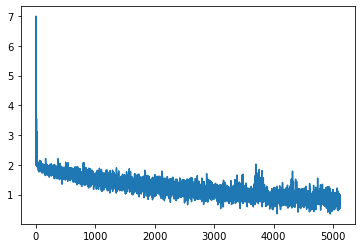

Confusion matrix for training:
tensor([[60.,  2.,  6.,  2.,  1.,  5.,  2.],
        [ 2., 43.,  3.,  4.,  3.,  2.,  3.],
        [ 2.,  0., 64.,  0.,  2.,  3.,  8.],
        [ 2.,  1.,  4., 59.,  5.,  2.,  2.],
        [ 4.,  1.,  6.,  3., 53.,  8.,  4.],
        [ 6.,  0.,  7.,  3.,  0., 57.,  5.],
        [ 4.,  2.,  8.,  2.,  3.,  7., 53.]])
Testing Accuracy: 21.77 %
Confusion matrix for testing:
tensor([[ 4.,  0.,  4.,  4.,  2.,  3.,  5.],
        [ 3.,  2.,  6.,  1.,  1.,  2.,  0.],
        [ 2.,  2., 12.,  1.,  1.,  2.,  1.],
        [ 6.,  5.,  1.,  4.,  1.,  6.,  2.],
        [ 3.,  0.,  4.,  1.,  4.,  2.,  7.],
        [ 5.,  2.,  4.,  6.,  1.,  2.,  2.],
        [ 2.,  2.,  3.,  2.,  5.,  3.,  4.]])


In [9]:
all_losses = []
num_epochs = 301

# train the model by batch
for epoch in range(num_epochs):
    total = 0
    correct = 0
    total_loss = 0
    for step, (batch_x, batch_y) in enumerate(train_LPQ_loader):
        X = batch_x
        Y = batch_y.long()

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(X)
        loss = criterion(outputs, Y)
        all_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        if (epoch % 50 == 0):
            _, predicted = torch.max(outputs, 1)
            # calculate and print accuracy
            total = total + predicted.size(0)
            correct = correct + sum(predicted.data.numpy() == Y.data.numpy())
            total_loss = total_loss + loss
    if (epoch % 50 == 0):
        print('Epoch [%d/%d], Loss: %.4f, Accuracy: %.2f %%'
              % (epoch + 1, num_epochs,
                 total_loss, 100 * correct/total))

import matplotlib.pyplot as plt
#
plt.figure()
plt.plot(all_losses)
plt.show()

outputs = net(train_LPQ_x)
_, predicted = torch.max(outputs, 1)

print('Confusion matrix for training:')
print(plot_confusion(train_LPQ_x.shape[0], 7, predicted.long().data, train_y.data))

#LPQ testing
outputs = net(test_LPQ_x)
_, predicted = torch.max(outputs, 1)

total = predicted.size(0)
correct = predicted.data.numpy() == test_y.data.numpy()

print('Testing Accuracy: %.2f %%' % (100 * sum(correct)/total))

print('Confusion matrix for testing:')
print(plot_confusion(test_LPQ_x.shape[0], 7, predicted.long().data, test_y.data))

In [ ]:
all_losses = []
num_epochs = 301

# train the model by batch
for epoch in range(num_epochs):
    for step, (batch_x, batch_y) in enumerate(train_LPQ_loader):
        X = batch_x
        Y = batch_y.long()

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(X)
        loss = criterion(outputs, Y)
        all_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        if (epoch % 50 == 0):
            _, predicted = torch.max(outputs, 1)
            # calculate and print accuracy
            total = total + predicted.size(0)
            correct = correct + sum(predicted.data.numpy() == Y.data.numpy())
            total_loss = total_loss + loss
    if (epoch % 50 == 0):
        print('Epoch [%d/%d], Loss: %.4f, Accuracy: %.2f %%'
              % (epoch + 1, num_epochs,
                 total_loss, 100 * correct/total))

import matplotlib.pyplot as plt
#
plt.figure()
plt.plot(all_losses)
plt.show()

outputs = net(train_LPQ_x)
_, predicted = torch.max(outputs, 1)

print('Confusion matrix for training:')
print(plot_confusion(train_LPQ_x.shape[0], 7, predicted.long().data, train_y.data))

#LPQ testing
outputs = net(test_LPQ_x)
_, predicted = torch.max(outputs, 1)

total = predicted.size(0)
correct = predicted.data.numpy() == test_y.data.numpy()

print('Testing Accuracy: %.2f %%' % (100 * sum(correct)/total))

print('Confusion matrix for testing:')
print(plot_confusion(test_LPQ_x.shape[0], 7, predicted.long().data, test_y.data))

Epoch [1/301], Loss: nan, Accuracy: 16.07 %
Epoch [51/301], Loss: nan, Accuracy: 13.80 %
Epoch [101/301], Loss: nan, Accuracy: 13.80 %
Epoch [151/301], Loss: nan, Accuracy: 13.80 %
Epoch [201/301], Loss: nan, Accuracy: 13.80 %
Epoch [251/301], Loss: nan, Accuracy: 13.80 %
Epoch [301/301], Loss: nan, Accuracy: 13.80 %


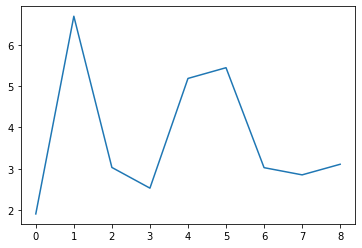

Confusion matrix for training:
tensor([[73.,  0.,  0.,  0.,  0.,  0.,  0.],
        [52.,  0.,  0.,  0.,  0.,  0.,  0.],
        [79.,  0.,  0.,  0.,  0.,  0.,  0.],
        [80.,  0.,  0.,  0.,  0.,  0.,  0.],
        [84.,  0.,  0.,  0.,  0.,  0.,  0.],
        [76.,  0.,  0.,  0.,  0.,  0.,  0.],
        [85.,  0.,  0.,  0.,  0.,  0.,  0.]])
Testing Accuracy: 18.49 %
Confusion matrix for testing:
tensor([[27.,  0.,  0.,  0.,  0.,  0.,  0.],
        [23.,  0.,  0.,  0.,  0.,  0.,  0.],
        [21.,  0.,  0.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.,  0.,  0.],
        [16.,  0.,  0.,  0.,  0.,  0.,  0.],
        [24.,  0.,  0.,  0.,  0.,  0.,  0.],
        [15.,  0.,  0.,  0.,  0.,  0.,  0.]])


In [211]:
all_losses = []

# train the model by batch
for epoch in range(num_epochs):
    total = 0
    correct = 0
    total_loss = 0
    for step, (batch_x, batch_y) in enumerate(train_PHOG_loader):
        X = batch_x
        Y = batch_y.long()

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(X)
        loss = criterion(outputs, Y)
        all_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        if (epoch % 50 == 0):
            _, predicted = torch.max(outputs, 1)
            # calculate and print accuracy
            total = total + predicted.size(0)
            correct = correct + sum(predicted.data.numpy() == Y.data.numpy())
            total_loss = total_loss + loss
    if (epoch % 50 == 0):
        print('Epoch [%d/%d], Loss: %.4f, Accuracy: %.2f %%'
              % (epoch + 1, num_epochs,
                 total_loss, 100 * correct/total))

import matplotlib.pyplot as plt
#
plt.figure()
plt.plot(all_losses)
plt.show()

outputs = net(train_PHOG_x)
_, predicted = torch.max(outputs, 1)

print('Confusion matrix for training:')
print(plot_confusion(train_PHOG_x.shape[0], 7, predicted.long().data, train_y.data))

#PHOG testing
outputs = net(test_PHOG_x)
_, predicted = torch.max(outputs, 1)

total = predicted.size(0)
correct = predicted.data.numpy() == test_y.data.numpy()

print('Testing Accuracy: %.2f %%' % (100 * sum(correct)/total))

print('Confusion matrix for testing:')
print(plot_confusion(test_PHOG_x.shape[0], 7, predicted.long().data, test_y.data))

In [179]:
train_combo_x = torch.Tensor(train_data.iloc[:, 0:10].values)
train_y = torch.Tensor(train_data.iloc[:, 10].values-1).long()

train_combo_dataset = torch.utils.data.TensorDataset(train_combo_x, train_y)

train_combo_loader = torch.utils.data.DataLoader(train_combo_dataset, batch_size=32, shuffle=True)

test_combo_x = torch.Tensor(test_data.iloc[:, 0:10].values)
test_y = torch.Tensor(test_data.iloc[:, 10].values-1).long()

In [183]:
class Net_combo(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net_combo, self).__init__()
        self.fc1 = nn.Linear(5, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out

net_combo = Net_combo(10, 50, 7)

In [186]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_combo.parameters(), lr=0.1)

Epoch [1/301], Loss: 13.0165, Accuracy: 71.97 %
Epoch [51/301], Loss: 14.8817, Accuracy: 67.05 %
Epoch [101/301], Loss: 12.3386, Accuracy: 72.35 %
Epoch [151/301], Loss: 11.1430, Accuracy: 73.67 %
Epoch [201/301], Loss: 10.6938, Accuracy: 76.89 %
Epoch [251/301], Loss: 14.8343, Accuracy: 68.18 %
Epoch [301/301], Loss: 10.2412, Accuracy: 76.14 %


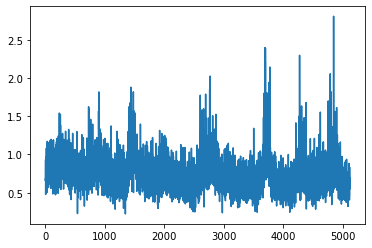

Confusion matrix for training:
tensor([[56.,  4.,  7.,  2.,  2.,  5.,  2.],
        [ 3., 49.,  3.,  2.,  2.,  0.,  1.],
        [ 2.,  0., 70.,  0.,  2.,  2.,  3.],
        [ 2.,  1.,  4., 62.,  2.,  3.,  1.],
        [ 0.,  4., 10.,  3., 57.,  3.,  2.],
        [ 2.,  2.,  6.,  4.,  2., 57.,  5.],
        [ 2.,  1., 11.,  3.,  3.,  3., 56.]])
Testing Accuracy: 26.53 %
Confusion matrix for testing:
tensor([[ 4.,  2.,  3.,  5.,  3.,  2.,  3.],
        [ 1.,  4.,  6.,  1.,  1.,  1.,  1.],
        [ 1.,  1., 15.,  1.,  1.,  1.,  1.],
        [ 3.,  3.,  2.,  7.,  2.,  4.,  4.],
        [ 5.,  1.,  5.,  2.,  3.,  2.,  3.],
        [ 3.,  3.,  4.,  4.,  4.,  2.,  2.],
        [ 0.,  4.,  4.,  3.,  5.,  1.,  4.]])


In [27]:
all_losses = []
num_epochs = 301

# train the model by batch
for epoch in range(num_epochs):
    total = 0
    correct = 0
    total_loss = 0
    for step, (batch_x, batch_y) in enumerate(train_LPQ_loader):
        X = batch_x
        Y = batch_y.long()

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(X)
        loss = criterion(outputs, Y)
        all_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        if (epoch % 50 == 0):
            _, predicted = torch.max(outputs, 1)
            # calculate and print accuracy
            total = total + predicted.size(0)
            correct = correct + sum(predicted.data.numpy() == Y.data.numpy())
            total_loss = total_loss + loss
    if (epoch % 50 == 0):
        print('Epoch [%d/%d], Loss: %.4f, Accuracy: %.2f %%'
              % (epoch + 1, num_epochs,
                 total_loss, 100 * correct/total))

import matplotlib.pyplot as plt
#
plt.figure()
plt.plot(all_losses)
plt.show()

outputs = net(train_LPQ_x)
_, predicted = torch.max(outputs, 1)

print('Confusion matrix for training:')
print(plot_confusion(train_LPQ_x.shape[0], 7, predicted.long().data, train_y.data))

#LPQ testing
outputs = net(test_LPQ_x)
_, predicted = torch.max(outputs, 1)

total = predicted.size(0)
correct = predicted.data.numpy() == test_y.data.numpy()

print('Testing Accuracy: %.2f %%' % (100 * sum(correct)/total))

print('Confusion matrix for testing:')
print(plot_confusion(test_LPQ_x.shape[0], 7, predicted.long().data, test_y.data))

In [30]:
def plot_prs(inputs, num_classes, targets, outputs):
    confusion = plot_confusion(inputs, num_classes, targets, outputs)
    prs = torch.zeros(3, num_classes)
    for i in range(num_classes):
        tp = confusion[i,i].item()
        fp = (sum(confusion[:,i])-confusion[i,i]).item()
        fn = (sum(confusion[i,:])-confusion[i,i]).item()
        tn = targets.size(0)-tp-fp-fn
        prs[:,i] = torch.Tensor([tp/(tp+fp),tp/(tp+fn),tn/(tn+fp)])
    return prs

print(plot_prs(test_LPQ_x.shape[0], 7, predicted.long().data, test_y.data))

tensor([[0.2353, 0.2222, 0.3846, 0.3043, 0.1579, 0.1538, 0.2222],
        [0.1818, 0.2667, 0.7143, 0.2800, 0.1429, 0.0909, 0.1905],
        [0.8960, 0.8939, 0.8095, 0.8689, 0.8730, 0.9120, 0.8889]])
